## Mobile Phone Price Classification_v2

Dataset Source: https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification?select=train.csv

##### Import Necessary Libraries

In [0]:
import re

import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler, RobustScaler, MinMaxScaler

from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, DecisionTreeClassifier, NaiveBayes, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

plt.rcParams['figure.figsize'] = [8, 8]

##### Ingest Data

In [0]:
# File location and type
file_location = "/FileStore/tables/train.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

schema = StructType([
    StructField("battery_power", IntegerType(), True),
    StructField("blue", IntegerType(), True),
    StructField("clock_speed", FloatType(), True),
    StructField("dual_sim", IntegerType(), True),
    StructField("fc", IntegerType(), True),
    StructField("four_g", IntegerType(), True),
    StructField("int_memory", IntegerType(), True),
    StructField("m_dep", FloatType(), True),
    StructField("mobile_weight", IntegerType(), True),
    StructField("n_cores", IntegerType(), True),
    StructField("pc", IntegerType(), True),
    StructField("px_height", IntegerType(), True),
    StructField("px_width", IntegerType(), True),
    StructField("ram", IntegerType(), True),
    StructField("sc_h", IntegerType(), True),
    StructField("sc_w", IntegerType(), True),
    StructField("talk_time", IntegerType(), True),
    StructField("three_g", IntegerType(), True),
    StructField("touch_screen", IntegerType(), True),
    StructField("wifi", IntegerType(), True),
    StructField("price_range", IntegerType(), True)
])

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .schema(schema)\
  .load(file_location)

df = df.dropDuplicates()

df = df.dropna()

cols = df.columns

display(df)

battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_weight,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
956,0,0.5,0,1,1,41,1.0,143,7,6,511,1075,3286,17,8,12,1,1,0,3
1414,0,2.0,1,2,0,54,0.8,99,7,3,262,829,3799,17,7,7,1,0,1,3
1567,0,0.5,1,3,0,22,0.5,119,6,6,545,1621,2312,9,1,18,1,0,0,2
1815,0,2.8,0,2,0,33,0.6,159,4,17,607,748,1482,18,0,2,1,0,0,1
790,0,2.0,1,16,1,11,0.3,87,6,17,347,730,3169,6,1,2,1,0,1,2
1310,1,1.1,1,13,0,7,1.0,194,5,14,117,513,3182,8,4,5,1,1,0,2
1589,0,2.5,0,5,1,51,0.8,195,1,18,810,1743,2612,8,2,16,1,0,0,2
1974,0,1.0,0,4,0,24,0.3,80,7,13,250,545,861,7,4,6,1,0,1,0
539,1,0.6,1,9,0,21,0.1,145,7,14,551,599,3597,14,5,9,0,0,0,2
1717,1,1.3,0,1,0,62,0.7,130,1,3,609,810,3226,6,4,5,0,1,0,3


Output can only be rendered in Databricks

##### Summary Information for Each Feature

In [0]:
part_one_summary = ["battery_power", "blue", "clock_speed", "dual_sim", "fc", "four_g", "int_memory"]

part_two_summary = ["m_dep", "mobile_weight", "n_cores", "pc", "px_height", "px_width", "ram"]

part_three_summary = [ "sc_h", "sc_w", "talk_time", "three_g", "touch_screen", "wifi", "price_range"]

df.describe(part_one_summary).show()

df.describe(part_two_summary).show()

df.describe(part_three_summary).show()

+-------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|     battery_power|             blue|       clock_speed|         dual_sim|               fc|            four_g|        int_memory|
+-------+------------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+
|  count|              2000|             2000|              2000|             2000|             2000|              2000|              2000|
|   mean|         1238.5185|            0.495|1.5222499980330466|           0.5095|           4.3095|            0.5215|           32.0465|
| stddev|439.41820608353106|0.500100040017008|0.8160042078159736|0.500034766175005|4.341443747983896|0.4996624673623638|18.145714955206863|
|    min|               501|                0|               0.5|                0|                0|                 0|                 2|
|    max|           

##### Show Unique Values in "price_range" (Label) Column

In [0]:
df.select("price_range").distinct().show()

+-----------+
|price_range|
+-----------+
|          1|
|          3|
|          2|
|          0|
+-----------+



##### Display Values by Type (In This Case: Integer vs Floating-Point)

In [0]:
# Integer Columns
int_columns = [item[0] for item in df.dtypes if item[1].startswith("int")]
print(f"Integer Columns ({len(int_columns)}):")
for x in int_columns: print(x, end=", ")

# Floating Point Columns
fp_columns = [item[0] for item in df.dtypes if item[1].startswith("float")]
print(f"\n\nFloating Point Columns ({len(fp_columns)}):")
for x in fp_columns: print(x, end=", ")

Integer Columns (19):
battery_power, blue, dual_sim, fc, four_g, int_memory, mobile_weight, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, talk_time, three_g, touch_screen, wifi, price_range, 

Floating Point Columns (2):
clock_speed, m_dep, 

##### Build Pipeline Stages

In [0]:
stages = []

categorical_columns = ["blue", "dual_sim", "four_g", "int_memory", "n_cores", "three_g", "touch_screen", "wifi"]

numerical_features = [c for c in df.columns if c not in ("price_range", categorical_columns)]

stages = []
for cat in categorical_columns:
    stringIndexer = StringIndexer(inputCol = cat, outputCol = cat + "_index")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[cat + "_class_vec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = "price_range", outputCol = "label")

stages += [label_stringIdx]

assembler_inputs = [c + "_class_vec" for c in categorical_columns] + numerical_features
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [assembler]

##### Build Pipeline & Apply it to Dataset

In [0]:
mobile_phone_pipe = Pipeline(stages = stages)
mobile_phone_model = mobile_phone_pipe.fit(df)
ds = mobile_phone_model.transform(df)

selectedCols = ["label", "features"] + cols
ds = ds.select(selectedCols)

##### Split Dataset into Training & Testing Datasets

In [0]:
train_ds, test_ds = ds.randomSplit(weights=[0.80, 0.20], seed=42)

print(f"# of Samples in Training Dataset: {train_ds.count()}")
print(f"# of Samples in Testing Dataset: {test_ds.count()}")

# of Samples in Training Dataset: 1642
# of Samples in Testing Dataset: 358


In [0]:
def metrics_eval(label, prediction, model_name: str) -> None:
    
    print("-------------------------------------------------------------")
    print(f"The {model_name} Model:")
    print(f"Classification Report for the {model_name} Model:")
    
    report = classification_report(label, prediction)
    print(report)
    print("-------------------------------------------------------------")
    
    print(f"Confusion Matrix for the {model_name} Model:")
    cm = confusion_matrix(label, prediction)
    dist = ConfusionMatrixDisplay(confusion_matrix=cm)
    dist.plot()
    
    print("-------------------------------------------------------------")

##### Decision Tree Classifier

-------------------------------------------------------------
The Decision Tree Classifier Model:
Classification Report for the Decision Tree Classifier Model:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95        74
         1.0       0.89      0.86      0.88        88
         2.0       0.76      0.92      0.83        96
         3.0       1.00      0.78      0.88       100

    accuracy                           0.88       358
   macro avg       0.89      0.89      0.88       358
weighted avg       0.89      0.88      0.88       358

-------------------------------------------------------------
Confusion Matrix for the Decision Tree Classifier Model:
-------------------------------------------------------------


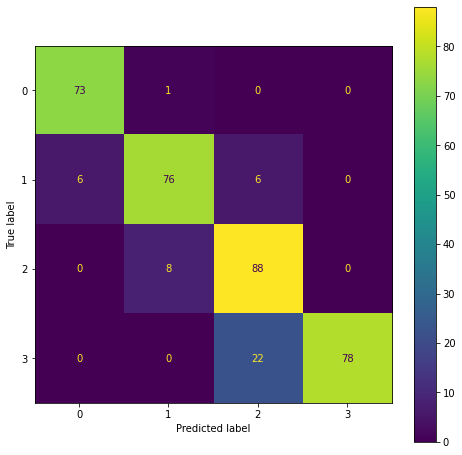

In [0]:
dec_tree = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 6)
dec_tree_model = dec_tree.fit(train_ds)
dec_tree_preds = dec_tree_model.transform(test_ds)

dt_preds_in_pandas = dec_tree_preds.select('label', 'prediction').toPandas()
#dt_preds_in_pandas = (dt_preds.select(F.col('label').alias("ground_truth"), F.col('prediction').alias("prediction"))).toPandas()
metrics_eval(dt_preds_in_pandas['label'], dt_preds_in_pandas['prediction'], "Decision Tree Classifier")

##### Random Forest Classifier

-------------------------------------------------------------
The Random Forest Classifier Model:
Classification Report for the Random Forest Classifier Model:
              precision    recall  f1-score   support

         0.0       0.64      0.95      0.77        74
         1.0       0.82      0.41      0.55        88
         2.0       0.68      0.78      0.72        96
         3.0       0.88      0.83      0.86       100

    accuracy                           0.74       358
   macro avg       0.75      0.74      0.72       358
weighted avg       0.76      0.74      0.73       358

-------------------------------------------------------------
Confusion Matrix for the Random Forest Classifier Model:
-------------------------------------------------------------


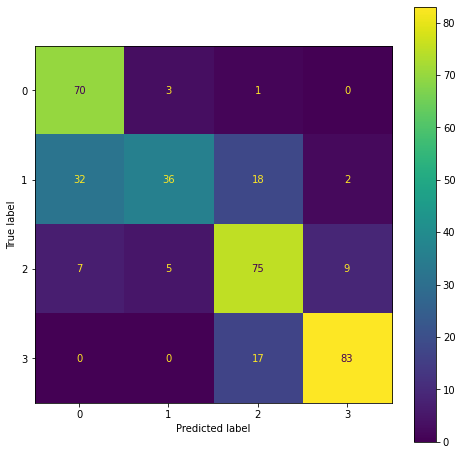

In [0]:
random_forest = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
random_forest_model = random_forest.fit(train_ds)
random_forest_preds = random_forest_model.transform(test_ds)

rf_preds_in_pandas = random_forest_preds.select('label', 'prediction').toPandas()
metrics_eval(rf_preds_in_pandas['label'], rf_preds_in_pandas['prediction'], "Random Forest Classifier")

##### Naive Bayes

-------------------------------------------------------------
The Naive Bayes Model:
Classification Report for the Naive Bayes Model:
              precision    recall  f1-score   support

         0.0       0.63      0.70      0.67        74
         1.0       0.38      0.36      0.37        88
         2.0       0.37      0.30      0.33        96
         3.0       0.55      0.63      0.59       100

    accuracy                           0.49       358
   macro avg       0.48      0.50      0.49       358
weighted avg       0.48      0.49      0.48       358

-------------------------------------------------------------
Confusion Matrix for the Naive Bayes Model:
-------------------------------------------------------------


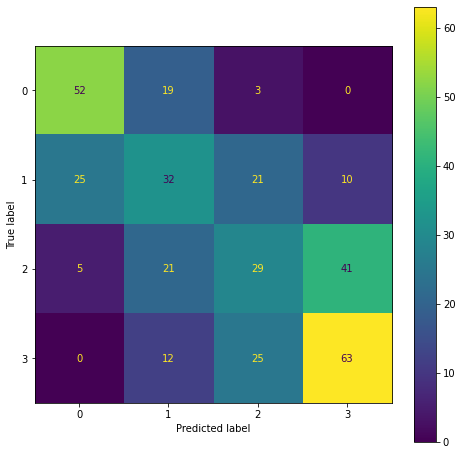

In [0]:
naive_bayes = NaiveBayes(smoothing=1.0, modelType="multinomial")
naive_bayes_model = naive_bayes.fit(train_ds)
naive_bayes_preds = naive_bayes_model.transform(test_ds)

nb_preds_in_pandas = naive_bayes_preds.select('label', 'prediction').toPandas()
metrics_eval(nb_preds_in_pandas['label'], nb_preds_in_pandas['prediction'], "Naive Bayes")

### Notes & Other Takewaways From This Project
****
- Ranking the models from best to worst according to the metrics:
  
  - Decision Tree Classifier
  - Random Forest Classifier
  - Naive Bayes Classifier
****
- This is a quicker update than originally expected. I discovered that I swapped the label and prediction arguments calling the metrics evaluation function.
****